# Data Sources

Get data 

## import

In [20]:
import os
import sys
import time
import datetime

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
#import yfinance as yf
import ccxt

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



## definitions

In [2]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2021-01-01 00:00:00"
LAST_DATE =  "2023-02-13 00:00:00"
TIMEFRAME = "1h"

path_save_df_eth = "data/df_eth.csv"
path_save_df_eth_2 = "data/df_eth_2.csv"
path_save_df_btc = "data/df_btc.csv"
path_save_df_btc_2 = "data/df_btc_2.csv"
path_save_df_bnb = "data/df_bnb.csv"
path_save_df_bnb_2 = "data/df_bnb_2.csv"

## Download data

In [3]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE



# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp)
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            from_timestamp += len(ohlcvs) * hour
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms')

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except:
        
        return False

def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missage dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in abosolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df


In [4]:
data_ok = check_data()
print(data_ok)

True


In [5]:
if not data_ok:
    exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
    })

    
    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        FIRST_DATE,  
        LAST_DATE,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:
    # simply reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)
    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)
    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

Reload data binance exchange from disk...
df_eth:  (18556, 7)
df_btc:  (18556, 7)
df_bnb:  (18556, 7)


In [6]:

data_ok_2 = check_data_2()

if not data_ok_2:

    kucoin = ccxt.kucoin({
        'rateLimit': 1,
        'enableRateLimit': True,
    })

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    # simply reload from disk
    print("Reload data kucoin exchange from disk...")
    df_eth_2 = pd.read_csv(path_save_df_eth_2)
    df_btc_2 = pd.read_csv(path_save_df_btc_2)
    df_bnb_2 = pd.read_csv(path_save_df_bnb_2)   

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
df_eth kucoin:  (18571, 7)
df_btc kucoin:  (18571, 7)
df_bnb kucoin:  (18571, 7)


In [7]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1609459200000,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00
1,1609462800000,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00
2,1609466400000,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00
3,1609470000000,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00
4,1609473600000,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00
...,...,...,...,...,...,...,...
18564,1676289600000,1486.07,1491.89,1484.06,1487.32,19492.91240,2023-02-13 12:00:00
18565,1676293200000,1487.31,1488.80,1477.66,1477.98,28307.80350,2023-02-13 13:00:00
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.36010,2023-02-13 14:00:00
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.65050,2023-02-13 15:00:00


In [8]:
df_test = fill_time_gap(df_eth, df_eth_2)

Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988


In [9]:
diff_time = df_eth["Time"].diff()
df_eth.iloc[np.argmax(diff_time)-5:np.argmax(diff_time)+5]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.29,3071.00,3031.03,3043.30,12167.10571,2021-08-12 21:00:00
5374,1628805600000,3043.35,3049.73,2985.91,2998.99,25773.04397,2021-08-12 22:00:00
5375,1628809200000,2999.00,3049.55,2998.99,3045.96,23688.80488,2021-08-12 23:00:00
5376,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.11420,2021-08-13 00:00:00
5377,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.03514,2021-08-13 01:00:00
5378,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.16757,2021-08-13 06:00:00
5379,1628838000000,3184.53,3231.83,3184.53,3222.99,58228.69375,2021-08-13 07:00:00
5380,1628841600000,3222.99,3251.20,3216.43,3234.95,47701.08929,2021-08-13 08:00:00
5381,1628845200000,3234.96,3249.00,3221.30,3225.38,26186.31119,2021-08-13 09:00:00
5382,1628848800000,3225.01,3260.25,3225.01,3235.57,33575.18407,2021-08-13 10:00:00


In [10]:
df_test.loc[np.argmax(diff_time)+2:np.argmax(diff_time)+12]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.29,3071.00,3031.03,3043.30,12167.105710,2021-08-12 21:00:00
5374,1628805600000,3043.35,3049.73,2985.91,2998.99,25773.043970,2021-08-12 22:00:00
5375,1628809200000,2999.00,3049.55,2998.99,3045.96,23688.804880,2021-08-12 23:00:00
5376,1628812800000,3046.11,3073.89,3033.80,3062.18,26306.114200,2021-08-13 00:00:00
5377,1628816400000,3062.18,3097.00,3055.30,3088.22,23702.035140,2021-08-13 01:00:00
5378,1628820000000,3088.58,3142.73,3086.21,3129.13,34888.391864,2021-08-13 02:00:00
5379,1628823600000,3129.20,3137.26,3110.73,3115.30,23092.746220,2021-08-13 03:00:00
5380,1628827200000,3115.45,3128.83,3091.70,3119.56,23571.037829,2021-08-13 04:00:00
5381,1628830800000,3119.67,3145.00,3110.00,3129.40,19218.890115,2021-08-13 05:00:00
5382,1628834400000,3088.23,3186.00,3088.22,3184.52,28370.167570,2021-08-13 06:00:00


In [11]:
df_eth_2.loc[np.argmax(diff_time)+2:np.argmax(diff_time)+12]

,Time,Open,High,Low,Close,Volume,date
5373,1628802000000,3066.09,3069.68,3031.21,3043.82,3772.980336,2021-08-12 21:00:00
5374,1628805600000,3043.82,3050.18,2985.06,2998.78,4431.694191,2021-08-12 22:00:00
5375,1628809200000,2999.48,3050.42,2998.71,3046.45,4501.299494,2021-08-12 23:00:00
5376,1628812800000,3046.46,3073.19,3034.18,3062.31,4863.296806,2021-08-13 00:00:00
5377,1628816400000,3063.12,3096.75,3056.01,3088.59,3366.518309,2021-08-13 01:00:00
5378,1628820000000,3088.58,3142.73,3086.21,3129.13,4955.372368,2021-08-13 02:00:00
5379,1628823600000,3129.20,3137.26,3110.73,3115.30,3279.977964,2021-08-13 03:00:00
5380,1628827200000,3115.45,3128.83,3091.70,3119.56,3347.912108,2021-08-13 04:00:00
5381,1628830800000,3119.67,3145.00,3110.00,3129.40,2729.754853,2021-08-13 05:00:00
5382,1628834400000,3129.40,3185.35,3116.84,3184.00,5997.736925,2021-08-13 06:00:00


In [12]:
df_eth = fill_time_gap(df_eth, df_eth_2)
df_btc = fill_time_gap(df_btc, df_btc_2)
df_bnb = fill_time_gap(df_bnb, df_bnb_2)

Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volume index 2742
Correcting volume index 2743
Correcting volume index 2618
Correcting volume index 2619
Correcting volume index 988
Correcting volume index 1538
Correcting volume index 5378
Correcting volume index 5379
Correcting volume index 5380
Correcting volume index 5381
Correcting volume index 6511
Correcting volume index 6512
Correcting volume index 2741
Correcting volum

In [13]:
df_eth["Time"].diff().value_counts()

3600000.0    18570
Name: Time, dtype: int64

## Tests

## Add indicators

Ichimoku 1h 1D 1W

In [15]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()

    return df_out

df_eth = add_ichimoku(df_eth)


In [16]:
df_eth[["ichi_kijun", "ichi_kijun_day", "ichi_kijun_week"]]

,ichi_kijun,ichi_kijun_day,ichi_kijun_week
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
18566,1507.010,1590.340,1516.48
18567,1507.010,1590.340,1516.48
18568,1504.975,1588.305,1516.48
18569,1504.975,1588.305,1516.48


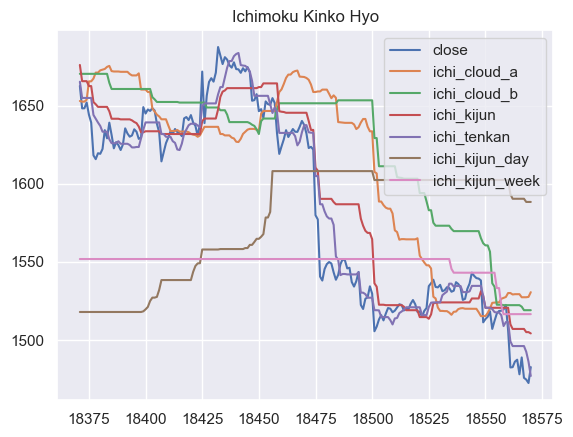

In [18]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [19]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=14).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=14*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=14*24*7).rsi()
    return df_out


df_out = add_rsi(df_eth)
df_out

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,30.187509,47.803232,49.865099
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,30.992124,47.826521,49.867644
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,30.071140,47.773766,49.861396
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,26.662544,47.563557,49.836441


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [36]:
# TODO calculate CHOP 
def add_chop(df, n):
    df_out = df.copy()
    #(high: pandas.core.series.Series, 
    # low: pandas.core.series.Series, 
    # close: pandas.core.series.Series, 
    # window: int = 14, 
    # fillna: bool = False)
    df_out["atr"] = AverageTrueRange(
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        window=1,
        ).average_true_range()
    
    sum_atr = df_out["atr"].rolling(n).sum()
    df_out["sum_atr"] = sum_atr
    max_high = df_out["High"].rolling(n).max()
    df_out["max_high"] = max_high
    min_low = df_out["Low"].rolling(n).min()
    df_out["min_low"] = min_low

    chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n)
    df_out["chop"] = chop
    return df_out

df_test = add_chop(df_eth, 14)
df_test[["date", "High", "Low", "Close", "atr","sum_atr", "max_high","min_low", "chop"]].tail(20)


,date,High,Low,Close,atr,sum_atr,max_high,min_low,chop
18551,2023-02-12 23:00:00,1517.42,1509.10,1514.83,8.32,152.74,1548.02,1493.08,38.744723
18552,2023-02-13 00:00:00,1524.62,1506.02,1518.29,18.60,164.25,1548.02,1493.08,41.497696
18553,2023-02-13 01:00:00,1520.00,1501.59,1507.03,18.41,179.04,1548.02,1493.08,44.764756
18554,2023-02-13 02:00:00,1512.71,1496.67,1512.14,16.04,180.89,1548.02,1493.08,45.154284
18555,2023-02-13 03:00:00,1518.00,1511.17,1516.81,6.83,180.60,1548.02,1493.08,45.093486
18556,2023-02-13 04:00:00,1522.71,1516.02,1518.51,6.69,174.29,1548.02,1493.08,43.745882
18557,2023-02-13 05:00:00,1520.95,1517.14,1518.66,3.81,167.10,1548.02,1493.08,42.149549
18558,2023-02-13 06:00:00,1520.06,1517.06,1519.41,3.00,156.31,1546.37,1493.08,40.775640
18559,2023-02-13 07:00:00,1526.10,1517.42,1522.39,8.68,158.39,1542.49,1493.08,44.141046
18560,2023-02-13 08:00:00,1522.83,1504.18,1506.19,18.65,172.59,1542.03,1493.08,47.748848


In [28]:
df_test

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_a_day,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,atr,sum_atr
0,1609459200000,736.42,739.00,729.33,734.07,27932.698840,2021-01-01 00:00:00,2327.873364,2320.213654,NaN,...,2353.31038,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,9.67,NaN
1,1609462800000,734.08,749.00,733.37,748.28,52336.187790,2021-01-01 01:00:00,2327.873364,2320.213654,NaN,...,2353.31038,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,15.63,NaN
2,1609466400000,748.27,749.00,742.27,744.06,33019.501000,2021-01-01 02:00:00,2327.873364,2320.213654,NaN,...,2353.31038,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,6.73,NaN
3,1609470000000,744.06,747.23,743.10,744.82,17604.808590,2021-01-01 03:00:00,2327.873364,2320.213654,NaN,...,2353.31038,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,4.13,NaN
4,1609473600000,744.87,747.09,739.30,742.29,18794.154240,2021-01-01 04:00:00,2327.873364,2320.213654,NaN,...,2353.31038,2335.408063,NaN,NaN,2578.146271,2553.25806,NaN,NaN,7.79,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18566,1676296800000,1477.99,1489.01,1477.69,1488.77,28081.360100,2023-02-13 14:00:00,1527.295000,1521.265000,1507.010,...,1429.03500,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,11.32,180.15
18567,1676300400000,1488.76,1489.78,1475.40,1475.71,23607.650500,2023-02-13 15:00:00,1527.295000,1519.005000,1507.010,...,1429.03500,1380.255000,1590.340,1581.955,1843.365000,2874.78000,1516.48,1432.595,14.38,176.12
18568,1676304000000,1475.71,1487.88,1461.93,1474.58,36687.889000,2023-02-13 16:00:00,1527.295000,1519.005000,1504.975,...,1429.03500,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,25.95,186.03
18569,1676307600000,1475.53,1480.29,1462.37,1472.40,2423.804905,2023-02-13 17:00:00,1527.530000,1519.005000,1504.975,...,1429.03500,1380.255000,1588.305,1579.920,1843.365000,2874.78000,1516.48,1432.595,17.92,197.12


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price
- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [ ]:
# TODO VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# TODO MVRV Z-score


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on each periods



In [ ]:
# TODO : NUPL ? 

Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [ ]:
# TODO : https://api.alternative.me/fng/?limit=370&format=csv



Other indicators : 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago
- STH-MVRV ? equiv to Price / VWAP of the last 6 months
- Dave’s Logarithmic Growth Curve ?

Others tickers:

- open interest 
- US02Y
- ETHBTC
- SP500
- NASDAC
- DXY



US02Y : 

In [91]:
# TODO : with yfinance ?

Open-Interest

In [58]:
df_eth

,Time,Open,High,Low,Close,Volume,date,volume_adi,volume_obv,volume_cmf,...,ichi_kijun,ichi_tenkan,ichi_tenkan_day,ichi_cloud_a_day,ichi_cloud_b_day,ichi_kijun_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week
0,1640995200000,3676.22,3730.00,3676.22,3723.04,9023.3740,2022-01-01 00:00:00,6.687834e+03,9.023374e+03,0.741168,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
1,1640998800000,3723.04,3748.45,3714.10,3724.89,8997.7569,2022-01-01 01:00:00,3.342816e+03,1.802113e+04,0.185494,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
2,1641002400000,3724.88,3738.47,3722.23,3728.32,5028.4531,2022-01-01 02:00:00,2.085703e+03,2.304958e+04,0.090488,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
3,1641006000000,3728.41,3737.00,3721.84,3723.96,3543.1853,2022-01-01 03:00:00,-4.665126e+02,1.950640e+04,-0.017543,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
4,1641009600000,3723.96,3728.07,3707.24,3708.21,6117.2820,2022-01-01 04:00:00,-6.014062e+03,1.338912e+04,-0.183860,...,NaN,NaN,NaN,1917.094078,2126.115562,NaN,1718.702279,2676.791045,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1673377200000,1341.08,1344.04,1338.50,1339.48,22563.0593,2023-01-10 19:00:00,-1.949739e+06,-8.520347e+06,0.139166,...,1329.995,1333.555,1268.955,1249.612500,1376.765000,1247.71,1948.707500,2391.145000,1518.16,1213.125
8996,1673380800000,1339.48,1347.69,1335.08,1341.98,22371.3361,2023-01-10 20:00:00,-1.947628e+06,-8.497976e+06,0.105158,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8997,1673384400000,1341.97,1343.21,1338.76,1339.01,14307.3162,2023-01-10 21:00:00,-1.960328e+06,-8.512283e+06,0.110837,...,1331.385,1335.380,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125
8998,1673388000000,1339.00,1339.45,1334.45,1334.46,11972.0830,2023-01-10 22:00:00,-1.972252e+06,-8.524255e+06,0.099342,...,1331.385,1336.135,1270.345,1249.612500,1376.765000,1249.10,1948.707500,2391.145000,1518.16,1213.125


In [80]:
df_eth.iloc[-1]["date"]

Timestamp('2023-01-10 23:00:00')

In [83]:
int(df_eth.iloc[-1]["date"].timestamp()*1000)

1673391600000

In [74]:
type(df_eth.iloc[-1]["date"])

pandas._libs.tslibs.timestamps.Timestamp

In [72]:
df_eth.iloc[-1]["date"].timestamp()

1673391600.0

In [68]:
type(int(df_eth.iloc[-1]["Time"]))

int

In [76]:
pd.Timestamp("2023-01-20 23:00:00").timestamp()

1674255600.0

In [89]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)

On-Chain data : 
  - Market Cap BTC ETH BNB
  - % Staked ETH
  - nb of address with ETH ?

Other infos :   
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [ ]:
# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
# TODO add sin/cos of day/week/month/year/halving cycle (maybe to short if only 2 year) ?
# TODO 

In [79]:
int(pd.Timestamp("2023-01-20 23:00:00").timestamp())

1674255600

In [35]:
df_test = ta.add_all_ta_features(df_eth, "Open", "High", "Low", "Close", "Volume", fillna=True)
print(df_test.shape)
df_test

8800   2023-01-02 16:00:00
8801   2023-01-02 17:00:00
8802   2023-01-02 18:00:00
8803   2023-01-02 19:00:00
8804   2023-01-02 20:00:00
               ...        
8995   2023-01-10 19:00:00
8996   2023-01-10 20:00:00
8997   2023-01-10 21:00:00
8998   2023-01-10 22:00:00
8999   2023-01-10 23:00:00
Name: date, Length: 200, dtype: datetime64[ns]

In [41]:
df_test.columns.to_list()

['Time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'date',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 '

In [44]:
df_test["momentum_rsi"]

0       100.000000
1       100.000000
2       100.000000
3        52.298392
4        18.313576
           ...    
8995     63.624256
8996     65.489364
8997     61.457829
8998     55.791435
8999     56.882902
Name: momentum_rsi, Length: 9000, dtype: float64